# lifelines - predictive maintenance

## Importing the libraries

In [185]:
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Importing the dataset

In [186]:
# pyspark_df = spark.table("sd_bdc_demo.sarima_time_series_forecasting.1_service_now_survival_data")
# pyspark_df.display()
# df = pyspark_df.toPandas()

In [187]:
df = pd.read_csv("2_maintenance_updated_data/2_maintenance_updated_data.csv")


In [188]:
print(df.head())

   lifetime  broken  pressureInd  moistureInd  temperatureInd  \
0        56       0           92          104              96   
1        81       1           72          103              87   
2        60       0           96           77             112   
3        86       1           94          108              72   
4        34       0           97           99             103   

   provider_Provider2  provider_Provider3  provider_Provider4  team_TeamB  \
0                   0                   0                   1           0   
1                   0                   0                   1           0   
2                   0                   0                   0           0   
3                   1                   0                   0           0   
4                   0                   0                   0           1   

   team_TeamC  
0           0  
1           1  
2           0  
3           1  
4           0  


In [189]:
print(df.columns)

Index(['lifetime', 'broken', 'pressureInd', 'moistureInd', 'temperatureInd',
       'provider_Provider2', 'provider_Provider3', 'provider_Provider4',
       'team_TeamB', 'team_TeamC'],
      dtype='object')


In [190]:
print(df.dtypes)

lifetime              int64
broken                int64
pressureInd           int64
moistureInd           int64
temperatureInd        int64
provider_Provider2    int64
provider_Provider3    int64
provider_Provider4    int64
team_TeamB            int64
team_TeamC            int64
dtype: object


In [191]:
print(df.shape)

(1000, 10)


## Train Test split

In [192]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

## The Weibull AFT model

In [193]:
from lifelines import WeibullAFTFitter
aft = WeibullAFTFitter()
training_timestamp = datetime.now().strftime("%m/%d/%Y %H:%M")
print(training_timestamp)
aft.fit(df_train, duration_col='lifetime', event_col='broken')

06/24/2025 16:06


<lifelines.WeibullAFTFitter: fitted with 800 total observations, 483 right-censored observations>

In [194]:
aft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 800 total observations, 483 right-censored observations>
             duration col = 'lifetime'
                event col = 'broken'
   number of observations = 800
number of events observed = 317
           log-likelihood = -54.23
         time fit was run = 2025-06-24 10:36:16 UTC

---
                            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                           
lambda_ moistureInd         0.00      1.00      0.00            0.00            0.00                1.00                1.00
        pressureInd        -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
        provider_Provider2  0.15      1.16      0.00            0.15            0.15                1.16                1.16
        provider_Provider3 -0.20      0.82      0.00           -0.20           -0.20                0.82                0.82
        provider_Provider4  0.10      1.10      0.00            0.10            0.10                1.10                1.10
        team_TeamB         -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
        team_TeamC         -0.08      0.92      0.00           -0.08           -0.08                0.92                0.92
        temperatureInd     -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
        Intercept           4.39     80.61      0.00            4.38            4.39               80.23               81.00
rho_    Intercept           5.72    305.02      0.04            5.64            5.80              280.67              331.48

                            cmp to       z      p  -log2(p)
param   covariate                                          
lambda_ moistureInd           0.00    5.06 <0.005     21.17
        pressureInd           0.00   -1.60   0.11      3.18
        provider_Provider2    0.00  287.90 <0.005       inf
        provider_Provider3    0.00 -407.19 <0.005       inf
        provider_Provider4    0.00  176.16 <0.005       inf
        team_TeamB            0.00   -1.65   0.10      3.35
        team_TeamC            0.00 -169.57 <0.005       inf
        temperatureInd        0.00  -19.68 <0.005    283.87
        Intercept             0.00 1785.76 <0.005       inf
rho_    Intercept             0.00  134.77 <0.005       inf
---
Concordance = 1.00
AIC = 128.46
log-likelihood ratio test = 2363.99 on 8 df
-log2(p) of ll-ratio test = inf

In [195]:
print(aft.median_survival_time_)
print(aft.mean_survival_time_)

79.8434266869609
79.78899586527906


### Saving summary table

In [196]:
summary_df = aft.summary.copy()
summary_df = summary_df.reset_index()
summary_df = summary_df.rename(columns={"index": "Parameter"})



In [197]:
# Create the folder if it doesn't exist
os.makedirs("3_1_maintenance_aft_model_train_summary_data", exist_ok=True)

# Save the Excel file inside the folder
summary_df.to_csv("3_1_maintenance_aft_model_train_summary_data/3_1_maintenance_aft_model_train_summary_data.csv", index=False)

### Saving meta data

In [198]:
meta_info = {
    "Model": str(type(aft)),
    "Duration column": 'lifetime',
    "Event column": 'broken',
    "Number of observations": df_train.shape[0],
    "Number of events observed": df_train['broken'].sum(),
    "Log-likelihood": aft.log_likelihood_,
    "Concordance": aft.concordance_index_,
    "AIC": aft.AIC_,
    "LLR test": aft.log_likelihood_ratio_test().test_statistic,
    "LLR df_train": aft.log_likelihood_ratio_test().degrees_freedom,
    "-log2(p) of LLR": -np.log2(aft.log_likelihood_ratio_test().p_value)
}

# Convert to DataFrame
meta_df = pd.DataFrame(list(meta_info.items()), columns=["Metric", "Value"])

C:\Users\LakshmanNavaneethakr\AppData\Local\Temp\ipykernel_23568\2825586005.py:12: RuntimeWarning: divide by zero encountered in log2
  "-log2(p) of LLR": -np.log2(aft.log_likelihood_ratio_test().p_value)


In [199]:
# Create the folder if it doesn't exist
os.makedirs("3_2_maintenance_aft_model_train_meta_data", exist_ok=True)

# Save the Excel file inside the folder
meta_df.to_csv("3_2_maintenance_aft_model_train_meta_data/3_2_maintenance_aft_model_train_meta_data.csv", index=False)

## Plotting

<Axes: xlabel='log(accelerated failure rate) (95% CI)'>

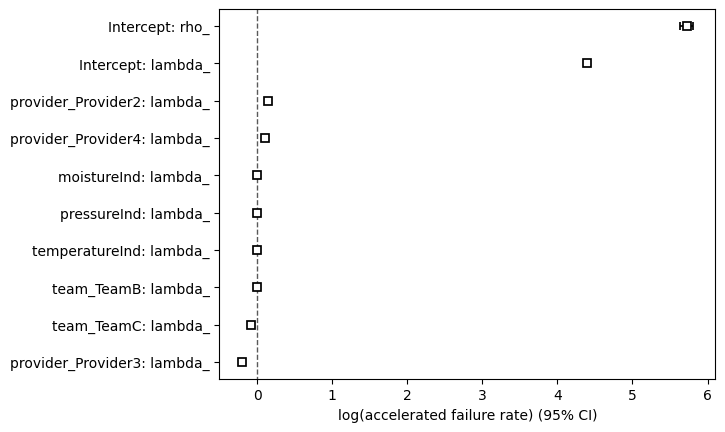

In [200]:
from matplotlib import pyplot as plt

aft.plot()

### Survival Function curve on all row

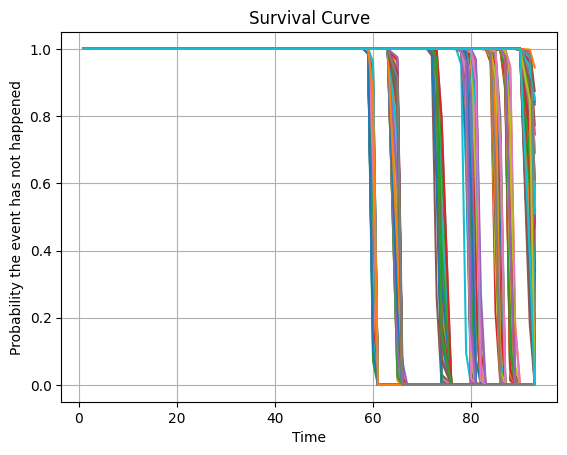

In [201]:
import matplotlib.pyplot as plt

# Curve for all rows
row = df_train

# Predict and plot survival curve
S = aft.predict_survival_function(row)
ax = S.plot()
ax.set_title("Survival Curve")
ax.set_xlabel("Time")
ax.set_ylabel("Probability the event has not happened")
ax.grid(True)
ax.get_legend().remove()
plt.show()


### Survival Function curve on 0th row

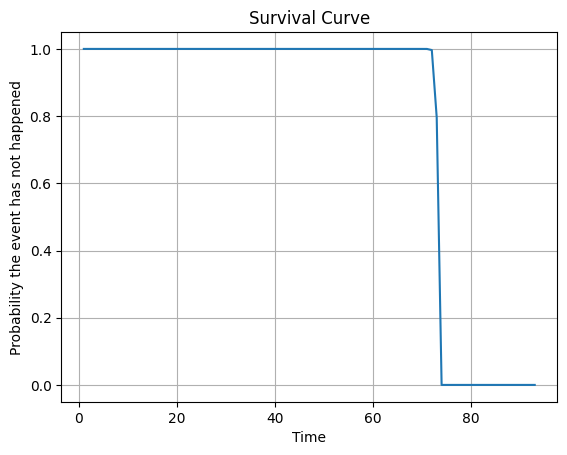

In [202]:
# Curve for 0th row
row = df_train.iloc[[0]]

# Predict and plot survival curve
S = aft.predict_survival_function(row)
ax = S.plot()
ax.set_title("Survival Curve")
ax.set_xlabel("Time")
ax.set_ylabel("Probability the event has not happened")
ax.grid(True)
ax.get_legend().remove()
plt.show()

## Prediction
| Method                         | Meaning                                                                | Suitable for "next likely event"?                                 |
| ------------------------------ | ---------------------------------------------------------------------- | ----------------------------------------------------------------- |
| `predict_median(X)`            | **Time at which there’s a 50% chance** the subject will have the event | ✅ Yes — this is the best estimate                                 |
| `predict_percentile(X, p=0.9)` | Time when **90% chance of event** has occurred                         | ❌ No — this is more pessimistic                                   |
| `predict_expectation(X)`       | **Average** (expected) time to event                                   | ✅ Optional — but less robust due to sensitivity to extreme values |


In [203]:
aft.predict_cumulative_hazard(df_test)

,521,737,740,660,411,678,626,513,859,136,...,948,829,656,199,213,408,332,208,613,78
1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88.0,8.405168e-01,6.894819e+38,9.073135e+39,1.663704e+12,2.838349e-07,5.021915e-07,1.081938e+14,4.236831e-08,2.109444e-07,1.644448e+10,...,2.839113e-07,3.055352e+38,1.655922e+39,8.855402e+11,9.034678e+12,1.512603e+13,1.421759e-01,5.385632e+10,9.961196e+39,3.061442e+00
89.0,2.638720e+01,2.164561e+40,2.848422e+41,5.223037e+13,8.910717e-06,1.576581e-05,3.396638e+15,1.330112e-06,6.622394e-06,5.162582e+11,...,8.913118e-06,9.591978e+39,5.198606e+40,2.780067e+13,2.836349e+14,4.748669e+14,4.463474e+00,1.690766e+12,3.127220e+41,9.611098e+01
90.0,7.971046e+02,6.538706e+41,8.604513e+42,1.577775e+15,2.691749e-04,4.762536e-04,1.026056e+17,4.018002e-05,2.000493e-04,1.559513e+13,...,2.692475e-04,2.897545e+41,1.570395e+42,8.398026e+14,8.568042e+15,1.434478e+16,1.348326e+02,5.107467e+13,9.446706e+42,2.903321e+03
92.0,6.502060e+05,5.333687e+44,7.018786e+45,1.287007e+18,2.195687e-01,3.884848e-01,8.369644e+19,3.277523e-02,1.631822e-01,1.272110e+16,...,2.196278e-01,2.363556e+44,1.280987e+45,6.850352e+17,6.989037e+18,1.170118e+19,1.099843e+05,4.166211e+16,7.705771e+45,2.368267e+06


In [204]:
aft.predict_survival_function(df_test)

,521,737,740,660,411,678,626,513,859,136,...,948,829,656,199,213,408,332,208,613,78
1.0,1.000000e+00,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000e+00,1.0,1.0,1.000000e+00
2.0,1.000000e+00,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000e+00,1.0,1.0,1.000000e+00
3.0,1.000000e+00,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000e+00,1.0,1.0,1.000000e+00
4.0,1.000000e+00,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000e+00,1.0,1.0,1.000000e+00
5.0,1.000000e+00,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000e+00,1.0,1.0,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88.0,4.314875e-01,0.0,0.0,0.0,1.000000,0.999999,0.0,1.000000,1.000000,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,8.674686e-01,0.0,0.0,4.682011e-02
89.0,3.468848e-12,0.0,0.0,0.0,0.999991,0.999984,0.0,0.999999,0.999993,0.0,...,0.999991,0.0,0.0,0.0,0.0,0.0,1.152227e-02,0.0,0.0,1.817743e-42
90.0,0.000000e+00,0.0,0.0,0.0,0.999731,0.999524,0.0,0.999960,0.999800,0.0,...,0.999731,0.0,0.0,0.0,0.0,0.0,2.772909e-59,0.0,0.0,0.000000e+00
92.0,0.000000e+00,0.0,0.0,0.0,0.802865,0.678084,0.0,0.967756,0.849436,0.0,...,0.802818,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00


In [205]:
aft.predict_median(df_test)

521    87.944401
737    65.558764
740    65.007192
660    80.148365
411    92.347387
         ...    
408    79.570445
332    88.458229
208    81.054854
613    64.987293
78     87.572499
Length: 200, dtype: float64

In [206]:
aft.predict_percentile(df_test, p=0.9)

521    87.402920
737    65.155113
740    64.606937
660    79.654884
411    91.778796
         ...    
408    79.080523
332    87.913585
208    80.555792
613    64.587161
78     87.033308
Length: 200, dtype: float64

In [207]:
aft.predict_expectation(df_test)

521    87.884448
737    65.514071
740    64.962875
660    80.093726
411    92.284432
         ...    
408    79.516200
332    88.397926
208    80.999597
613    64.942990
78     87.512799
Length: 200, dtype: float64

## Save the table

In [208]:
predicted_median = aft.predict_median(df_test)

# Step 2: Combine the actual and predicted into one DataFrame
result_df = pd.DataFrame({
    "index": df_test.index,
    "actual_lifetime": df_test["lifetime"].values,
    "actual_event": df_test["broken"].values,
    "predicted_median_time": predicted_median.values
})

result_df.reset_index(drop=True, inplace=True)



In [209]:
# Create the folder if it doesn't exist
os.makedirs("3_3_maintenance_aft_predicted_data", exist_ok=True)

# Save the Excel file inside the folder
result_df.to_csv("3_3_maintenance_aft_predicted_data/3_3_maintenance_aft_predicted_data.csv", index=False)

## Saving regression Evaluation Metrics

In [210]:
mask_event_1 = df_test["broken"] == 1
actual_lifetime = df_test.loc[mask_event_1, "lifetime"]
X_event_1 = df_test.loc[mask_event_1]


In [211]:
predicted_lifetime_event_1 = aft.predict_median(X_event_1)


In [212]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

r2 = r2_score(actual_lifetime, predicted_lifetime_event_1)
mae = mean_absolute_error(actual_lifetime, predicted_lifetime_event_1)
rmse = np.sqrt(mean_squared_error(actual_lifetime, predicted_lifetime_event_1))
mape = mean_absolute_percentage_error(actual_lifetime, predicted_lifetime_event_1)
Accuracy = 100 - (mape*100)


In [213]:
# Model Run Id
model_type_abbr = "waft"
project_name = "predictive_maintenance"
timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
model_run_id = f"{model_type_abbr}_{project_name}_{timestamp_str}"

# Model Type
model_type = "WeibullAFTFitter"

# model version 
version_file = "3_4_maintenance_aft_metrics_data.csv"
if os.path.exists(version_file):
    versions_df = pd.read_csv(version_file)
    max_version = versions_df[versions_df["model_type"] == model_type]["model_version"].max()
    model_version = int(max_version) + 1
else:
    model_version = 1

# training_timestamp
training_timestamp = training_timestamp

# dataset size
dataset_size = df_test.shape[0]

# feature count
feature_count = df_test.shape[1] 

# ==== Create metrics DataFrame ====
metrics_df = pd.DataFrame([{
    "model_run_id": model_run_id,
    "model_type": model_type,
    "model_version": model_version,
    "training_timestamp": training_timestamp,
    "dataset_size": dataset_size,
    "feature_count": feature_count,
    "regression_accuracy": Accuracy,
    "r2": r2,
    "mae": mae,
    "rmse": rmse,
    "mape": mape
}])




In [214]:
# Create the folder if it doesn't exist
os.makedirs("3_4_maintenance_aft_metrics_data", exist_ok=True)

# Save the Excel file inside the folder
metrics_df.to_csv("3_4_maintenance_aft_metrics_data/3_4_maintenance_aft_metrics_data.csv", index=False)
